
---

This script implements a Gurobi-based routing optimization model that determines efficient travel paths for technicians assigned to farmers while ensuring that each route visits the office at least once for straw refilling. It minimizes the total travel distance, ensures all assigned farmers are visited, and uses MTZ constraints to eliminate subtours.

---

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 45.9 MB/s eta 0:00:00


### Routing without the straws

---
To demonstrate the solution of the bi-objective optimization problem, we use a sample network consisting of 12 nodes (representing the office, technicians, and farmers) interconnected by 20 edges.

---


This model demonstrates technician route planning using Gurobi. Given a predefined distance matrix and farmer-to-technician assignments, the goal is to minimize the total travel distance for each technician while ensuring the following:

* Each **technician starts and ends at their origin** node.
* All **assigned farmers** are **visited exactly once**.
* The **office node is visited at least once** (for straw refill).
* Routes are **valid and do not contain subtours**, enforced using the **Miller–Tucker–Zemlin (MTZ) constraints**.

---

This sample assignment is based on the results from the previous formulation, which optimized resource allocation by minimizing total travel distance and straw usage. It serves as the input for testing the routing optimization, with Technician 4 assigned to farmers 0, 2, 6, and 7, and Technician 8 to farmers 3, 5, 9, 10, and 11. The office is located at node 1 and must be visited at least once in each technician’s route.

---

In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Distance matrix
distance = np.array([
    [0, 15, 0, 0, 24, 0, 18, 0, 0, 0, 0, 0],
    [15, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 22, 0, 18, 16, 0, 0, 0, 20, 0, 0, 0],
    [0, 0, 18, 0, 0, 12, 0, 0, 0, 0, 0, 0],
    [24, 0, 16, 0, 0, 0, 25, 12, 24, 0, 0, 0],
    [0, 0, 0, 12, 0, 0, 0, 0, 12, 0, 0, 22],
    [18, 0, 0, 0, 25, 0, 0, 15, 0, 22, 0, 0],
    [0, 0, 0, 0, 12, 0, 15, 0, 30, 0, 25, 0],
    [0, 0, 20, 0, 24, 12, 0, 30, 0, 0, 19, 19],
    [0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 19, 0],
    [0, 0, 0, 0, 0, 0, 0, 25, 19, 19, 0, 21],
    [0, 0, 0, 0, 0, 22, 0, 0, 19, 0, 21, 0]
])

technicians = [4, 8]
assigned_farmers = {
    4: [0, 2, 6, 7],
    8: [3, 5, 9, 10, 11]
}

office_node = 1
nodes = list(range(len(distance)))
N = len(nodes)

model = gp.Model("RoutingOnlyWithOffice")
model.Params.OutputFlag = 0

# Decision variables
x = model.addVars(
    [(i, j, t) for t in technicians for i in nodes for j in nodes if i != j and distance[i][j] > 0],
    vtype=GRB.BINARY, name="x"
)

# MTZ variables
u = model.addVars(nodes, technicians, lb=0, ub=N - 1, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize total travel distance
model.setObjective(gp.quicksum(x[i, j, t] * distance[i][j] for (i, j, t) in x), GRB.MINIMIZE)

for t in technicians:
    origin = t

    # Origin
    model.addConstr(gp.quicksum(x[origin, j, t] for j in nodes if j != origin and (origin, j, t) in x) == 1)
    model.addConstr(gp.quicksum(x[i, origin, t] for i in nodes if i != origin and (i, origin, t) in x) == 1)

    # Flow conservation
    for j in nodes:
        if j != origin:
            model.addConstr(
                gp.quicksum(x[i, j, t] for i in nodes if i != j and (i, j, t) in x) ==
                gp.quicksum(x[j, k, t] for k in nodes if k != j and (j, k, t) in x)
            )

    # Must visit all assigned farmers
    for f in assigned_farmers[t]:
        model.addConstr(gp.quicksum(x[i, f, t] for i in nodes if i != f and (i, f, t) in x) == 1)

    # Must visit the office at least once
    model.addConstr(gp.quicksum(x[i, office_node, t] for i in nodes if i != office_node and (i, office_node, t) in x) >= 1)

    # MTZ subtour elimination
    for i in nodes:
        for j in nodes:
            if i != j and i != origin and j != origin and (i, j, t) in x:
                model.addConstr(u[i, t] - u[j, t] + N * x[i, j, t] <= N - 1)

model.optimize()


routes = {}
if model.status == GRB.OPTIMAL:
    for t in technicians:
        route = [t]
        current = t
        visited_edges = set()
        while True:
            next_node = None
            for j in nodes:
                if (current, j, t) in x and x[current, j, t].X > 0.5 and (current, j) not in visited_edges:
                    next_node = j
                    visited_edges.add((current, j))
                    route.append(j)
                    current = j
                    break
            if next_node is None or current == t:
                break
        routes[t] = route

        # Print route
        print(f"\n🛠 Technician {t} Route:")
        total_distance = 0
        for idx in range(1, len(route)):
            from_node = route[idx - 1]
            to_node = route[idx]
            step_distance = distance[from_node][to_node]
            total_distance += step_distance
            node_type = "🧑 Origin" if to_node == t else (
                "🏢 Office" if to_node == office_node else (
                    "🐃 Farmer" if to_node in assigned_farmers[t] else "➡️ Traverse"
                )
            )
            print(f"  {from_node} → {to_node} | {node_type} | Distance: {step_distance}")
        print(f"📏 Total Distance: {total_distance} units\n")
else:
    print("❌ No optimal solution found.")

Restricted license - for non-production use only - expires 2026-11-23

🛠 Technician 4 Route:
  4 → 2 | 🐃 Farmer | Distance: 16
  2 → 1 | 🏢 Office | Distance: 22
  1 → 0 | 🐃 Farmer | Distance: 15
  0 → 6 | 🐃 Farmer | Distance: 18
  6 → 7 | 🐃 Farmer | Distance: 15
  7 → 4 | 🧑 Origin | Distance: 12
📏 Total Distance: 98 units


🛠 Technician 8 Route:
  8 → 5 | 🐃 Farmer | Distance: 12
  5 → 3 | 🐃 Farmer | Distance: 12
  3 → 2 | ➡️ Traverse | Distance: 18
  2 → 1 | 🏢 Office | Distance: 22
  1 → 0 | ➡️ Traverse | Distance: 15
  0 → 6 | ➡️ Traverse | Distance: 18
  6 → 9 | 🐃 Farmer | Distance: 22
  9 → 10 | 🐃 Farmer | Distance: 19
  10 → 11 | 🐃 Farmer | Distance: 21
  11 → 8 | 🧑 Origin | Distance: 19
📏 Total Distance: 178 units



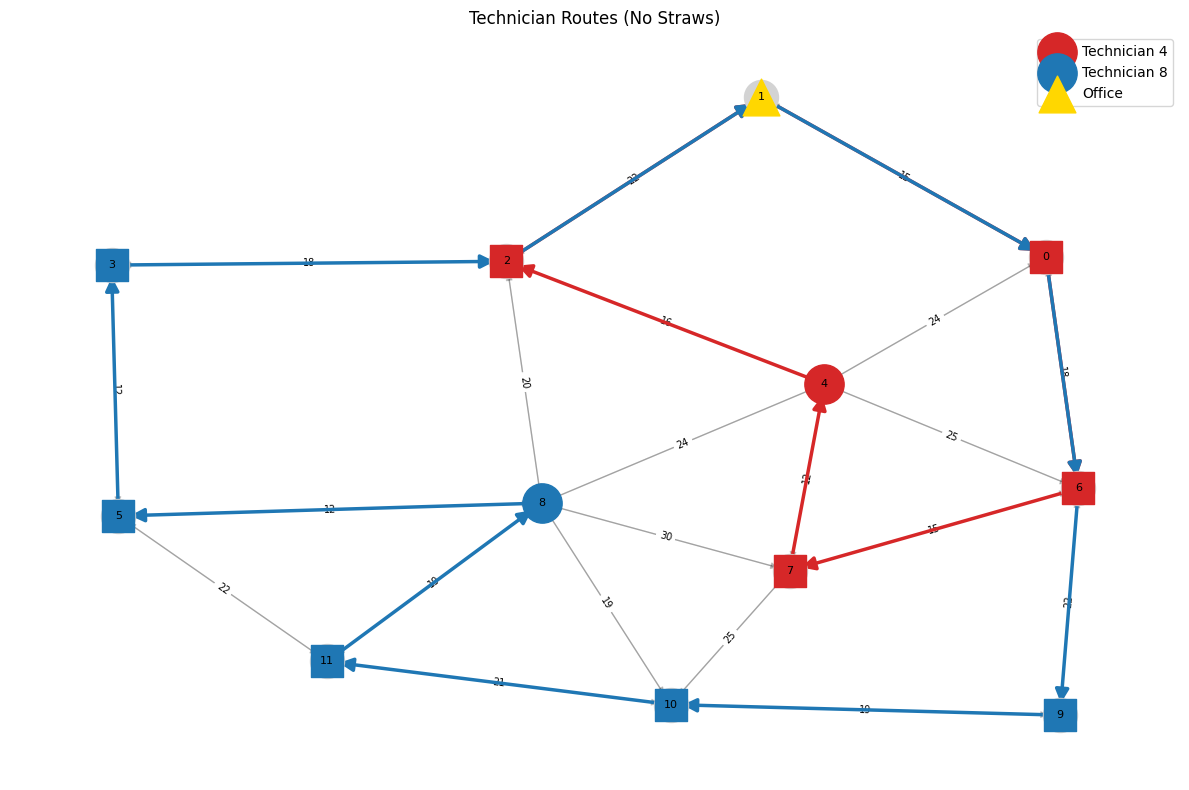

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_routes(distance_matrix, solution_edges, technicians, assignments, office_node):

    G = nx.DiGraph()
    n = len(distance_matrix)
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(n):
            if distance_matrix[i][j] != 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Basic node labels
    node_labels = {i: str(i) for i in range(n)}

    # Plot base network
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    # Technician-specific highlights
    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple']
    for idx, t in enumerate(technicians):
        tech_edges = [(i, j) for (i, j, tt) in solution_edges if tt == t]
        color = colors[idx % len(colors)]

        # Edges for this technician
        nx.draw_networkx_edges(G, pos, edgelist=tech_edges,
                               edge_color=color, width=2.5,
                               arrows=True, arrowsize=20, label=f'Tech {t}')

        # Origin node
        nx.draw_networkx_nodes(G, pos, nodelist=[t], node_color=color,
                               node_size=800, label=f'Technician {t}')

        # Assigned farmers
        assigned_nodes = assignments[t]
        nx.draw_networkx_nodes(G, pos, nodelist=assigned_nodes,
                               node_color=color, node_size=500, node_shape='s')

    # Office node
    nx.draw_networkx_nodes(G, pos, nodelist=[office_node], node_color='gold', node_shape='^', node_size=700, label='Office')

    plt.title("Technician Routes (No Straws)")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Extract edges from the solution
solution_edges = [(i, j, t) for (i, j, t) in x.keys() if x[i, j, t].X > 0.5]

# Plot
plot_routes(distance, solution_edges, technicians, assigned_farmers, office_node)

---

This is another sample assignment generated from the earlier resource optimization model. In this setup, Technician 0 is assigned to farmers 6 and 9, Technician 4 to farmers 1, 2, and 7, and Technician 5 to farmers 3, 10, and 11. The central office is located at node 8 and must be included in each technician’s route to allow for straw replenishment. This assignment will be used to test the routing optimization component.

---


In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Distance matrix
distance = np.array([
    [0, 15, 0, 0, 24, 0, 18, 0, 0, 0, 0, 0],
    [15, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 22, 0, 18, 16, 0, 0, 0, 20, 0, 0, 0],
    [0, 0, 18, 0, 0, 12, 0, 0, 0, 0, 0, 0],
    [24, 0, 16, 0, 0, 0, 25, 12, 24, 0, 0, 0],
    [0, 0, 0, 12, 0, 0, 0, 0, 12, 0, 0, 22],
    [18, 0, 0, 0, 25, 0, 0, 15, 0, 22, 0, 0],
    [0, 0, 0, 0, 12, 0, 15, 0, 30, 0, 25, 0],
    [0, 0, 20, 0, 24, 12, 0, 30, 0, 0, 19, 19],
    [0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 19, 0],
    [0, 0, 0, 0, 0, 0, 0, 25, 19, 19, 0, 21],
    [0, 0, 0, 0, 0, 22, 0, 0, 19, 0, 21, 0]
])

technicians = [0, 4, 5]
assigned_farmers = {
    0: [6,9],
    4: [1,2,7],
    5: [3,10,11]
}

office_node = 8
nodes = list(range(len(distance)))
N = len(nodes)

model = gp.Model("RoutingOnlyWithOffice")
model.Params.OutputFlag = 0

# Decision variables
x = model.addVars(
    [(i, j, t) for t in technicians for i in nodes for j in nodes if i != j and distance[i][j] > 0],
    vtype=GRB.BINARY, name="x"
)

# MTZ variables
u = model.addVars(nodes, technicians, lb=0, ub=N - 1, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize total travel distance
model.setObjective(gp.quicksum(x[i, j, t] * distance[i][j] for (i, j, t) in x), GRB.MINIMIZE)

for t in technicians:
    origin = t

    # Origin
    model.addConstr(gp.quicksum(x[origin, j, t] for j in nodes if j != origin and (origin, j, t) in x) == 1)
    model.addConstr(gp.quicksum(x[i, origin, t] for i in nodes if i != origin and (i, origin, t) in x) == 1)

    # Flow conservation
    for j in nodes:
        if j != origin:
            model.addConstr(
                gp.quicksum(x[i, j, t] for i in nodes if i != j and (i, j, t) in x) ==
                gp.quicksum(x[j, k, t] for k in nodes if k != j and (j, k, t) in x)
            )

    # Must visit all assigned farmers
    for f in assigned_farmers[t]:
        model.addConstr(gp.quicksum(x[i, f, t] for i in nodes if i != f and (i, f, t) in x) == 1)

    # Must visit the office at least once
    model.addConstr(gp.quicksum(x[i, office_node, t] for i in nodes if i != office_node and (i, office_node, t) in x) >= 1)

    # MTZ subtour elimination
    for i in nodes:
        for j in nodes:
            if i != j and i != origin and j != origin and (i, j, t) in x:
                model.addConstr(u[i, t] - u[j, t] + N * x[i, j, t] <= N - 1)

model.optimize()


routes = {}
if model.status == GRB.OPTIMAL:
    for t in technicians:
        route = [t]
        current = t
        visited_edges = set()
        while True:
            next_node = None
            for j in nodes:
                if (current, j, t) in x and x[current, j, t].X > 0.5 and (current, j) not in visited_edges:
                    next_node = j
                    visited_edges.add((current, j))
                    route.append(j)
                    current = j
                    break
            if next_node is None or current == t:
                break
        routes[t] = route

        # Print route
        print(f"\n🛠 Technician {t} Route:")
        total_distance = 0
        for idx in range(1, len(route)):
            from_node = route[idx - 1]
            to_node = route[idx]
            step_distance = distance[from_node][to_node]
            total_distance += step_distance
            node_type = "🧑 Origin" if to_node == t else (
                "🏢 Office" if to_node == office_node else (
                    "🐃 Farmer" if to_node in assigned_farmers[t] else "➡️ Traverse"
                )
            )
            print(f"  {from_node} → {to_node} | {node_type} | Distance: {step_distance}")
        print(f"📏 Total Distance: {total_distance} units\n")
else:
    print("❌ No optimal solution found.")


🛠 Technician 0 Route:
  0 → 4 | ➡️ Traverse | Distance: 24
  4 → 8 | 🏢 Office | Distance: 24
  8 → 10 | ➡️ Traverse | Distance: 19
  10 → 9 | 🐃 Farmer | Distance: 19
  9 → 6 | 🐃 Farmer | Distance: 22
  6 → 0 | 🧑 Origin | Distance: 18
📏 Total Distance: 126 units


🛠 Technician 4 Route:
  4 → 7 | 🐃 Farmer | Distance: 12
  7 → 8 | 🏢 Office | Distance: 30
  8 → 2 | 🐃 Farmer | Distance: 20
  2 → 1 | 🐃 Farmer | Distance: 22
  1 → 0 | ➡️ Traverse | Distance: 15
  0 → 4 | 🧑 Origin | Distance: 24
📏 Total Distance: 123 units


🛠 Technician 5 Route:
  5 → 11 | 🐃 Farmer | Distance: 22
  11 → 10 | 🐃 Farmer | Distance: 21
  10 → 8 | 🏢 Office | Distance: 19
  8 → 2 | ➡️ Traverse | Distance: 20
  2 → 3 | 🐃 Farmer | Distance: 18
  3 → 5 | 🧑 Origin | Distance: 12
📏 Total Distance: 112 units

